# Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wri/cities-urbanshift/blob/indicators-amenity-exposure/baseline-indicators/compute-exposure-amenity-lst.ipynb)


- Author: Saif Shabou
- Contact: Saif.Shabou@wri.org
- Last Edit: August 13, 2021

The goal of this script consists of computing indicators for assessing amenities' exposure to extreme heat events based on Land Surface Temperature data.


In [ ]:
#! pip install geopandas #geemap #geopandas #rasterio rioxarray earthpy

In [ ]:
from google.colab import auth
auth.authenticate_user()
from google.cloud import storage
import json
import rasterio 
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import pandas as pd
import branca.colormap as cm
import plotly.express as px

In [ ]:
# specify color palettes for plots
BoldRiverBlue =  '#242456'
BoldSunYellow =  '#FFD450'
BoldGrassGreen =  '#2A553E'
BoldEarthGrey =  '#7B7A66'
BoldBrickOrange =  '#F26640'
LightRiverBlue =  '#E3E6FF'
LightSunYellow =  '#FFEDBA'
LightGrassGreen =  '#C4F4D5'
LightEarthGrey =  '#ECE2D6'
LightBrickOrange =  '#FED3CF'
White = '#FFFFFF'
Black = '#000000'

# Load input data

## Load Administrative boundaries

In [ ]:
#admin_boundaries_allCities = gpd.read_file('https://storage.googleapis.com/urbanshift/administrative_boundaries/administrative_boundaries_allCities.geojson')
admin_boundaries_urbanshift_cities = gpd.read_file('https://storage.googleapis.com/urbanshift/administrative_boundaries/v1/administrative_boundaries_urbanshift_cities.geojson')


In [ ]:
admin_boundaries_urbanshift_cities.head()

,country_iso,id,name,shapeGroup,shapeID,shapeISO,shapeName,shapeType,ADM0_shape,ADM1_sha_1,ADM1_shape,ADMHIERARC,geometry,centroid_x,centroid_y
0,ARG,ARG-Mendoza,Mendoza,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-70.09376 -33.05128, -70.09369...",-69.292588,-32.722094
1,ARG,ARG-Mar_del_Plata,Mar del Plata,ARG,ARG-ADM2-1590546715-B389,ARG,Partido de General Pueyrred�n,ADM2,None,None,None,None,"MULTIPOLYGON (((-58.04728 -37.95562, -58.04717...",-57.743028,-37.965683
2,ARG,ARG-Ushuaia,Ushuaia,ARG,ARG-ADM2-1590546715-B99,ARG,Departamento Ushuaia,ADM2,None,None,None,None,"MULTIPOLYGON (((-64.35062 -54.84401, -64.35014...",-66.683717,-54.770462
3,ARG,ARG-Salta,Salta,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-65.53171 -25.02690, -65.53166...",-65.651931,-24.645888
4,ARG,ARG-Buenos_Aires,Buenos Aires,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-58.36618 -34.59744, -58.36609...",-58.526143,-34.521038


In [ ]:
# filter freetown
admin_boundaries_urbanshift_cities = admin_boundaries_urbanshift_cities.loc[admin_boundaries_urbanshift_cities['name'] != 'Freetown Core']
admin_boundaries_urbanshift_cities = admin_boundaries_urbanshift_cities.reset_index(drop=True)

In [ ]:
# add centroid coordinates
admin_boundaries_urbanshift_cities["centroid_x"] = admin_boundaries_urbanshift_cities.centroid.x
admin_boundaries_urbanshift_cities["centroid_y"] = admin_boundaries_urbanshift_cities.centroid.y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [ ]:
############################### plot a map of geoboundaries

# define map center coordinates
map_center_x = admin_boundaries_urbanshift_cities.centroid_x.mean()
map_center_y = admin_boundaries_urbanshift_cities.centroid_y.mean()

# plot map background
m = folium.Map()
m = folium.Map(location = [map_center_x,map_center_y],zoom_start=2)

# plot adminisrative boundaries
folium.GeoJson(
    admin_boundaries_urbanshift_cities,
    tooltip=folium.features.GeoJsonTooltip(fields=['country_iso','name'],
            aliases=['Country','City name'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
            sticky=True
        )
).add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.

## Load Amenity data

In [ ]:
# get amenity data
amenity_urbanshift_cities = gpd.read_file('https://storage.googleapis.com/urbanshift/amenity/amenity_all_cities.geojson')
amenity_urbanshift_cities.head()

,cityName,featureCategory,featureType,id,integrationDate,latitude,longitude,objectType,projectName,geometry
0,Mendoza,amenity,fuel,272174284,2021-08-03,-33.005630,-68.867760,amenity,urbanshift,POINT (-68.86776 -33.00563)
1,Mendoza,amenity,fuel,272174301,2021-08-03,-32.938090,-68.840430,amenity,urbanshift,POINT (-68.84043 -32.93809)
2,Mendoza,amenity,fuel,272174306,2021-08-03,-32.940225,-68.847488,amenity,urbanshift,POINT (-68.84749 -32.94023)
3,Mendoza,amenity,fuel,272174310,2021-08-03,-32.930245,-68.850123,amenity,urbanshift,POINT (-68.85012 -32.93024)
4,Mendoza,amenity,fuel,272174325,2021-08-03,-33.209606,-68.882347,amenity,urbanshift,POINT (-68.88235 -33.20961)


In [ ]:
#######################################################################################################################
#  plot amenity within one city  
#######################################################################################################################

# select city name
city_name = "Marrakech"
# select amenity data for the selectd city
city_amenity =  amenity_urbanshift_cities[amenity_urbanshift_cities.cityName == city_name]
# select boundaries data for the selected city
city_boundaries =  admin_boundaries_urbanshift_cities[admin_boundaries_urbanshift_cities.name == city_name]

# color definition in boundary polygon
style_function_Boundaries = lambda x: {
    'fillColor':LightEarthGrey,
    'color': BoldEarthGrey,
    'weight': 3.5,
    'fillOpacity': 0.3
}


# Plot map background
m = folium.Map(location=[float(city_boundaries["centroid_y"]), float(city_boundaries["centroid_x"])],
               zoom_start = 8)


# plot administrative boundaries of selected city
folium.GeoJson(
    city_boundaries,
    name = "Administrative boundaries",
    style_function=style_function_Boundaries,
).add_to(m)

# plot amenities of the selected city
for i in range(0,len(city_amenity)):
   folium.CircleMarker(
      location=[city_amenity.iloc[i]['latitude'], city_amenity.iloc[i]['longitude']],
      popup=city_amenity.iloc[i]['featureType'],
      radius=2,
      color=BoldRiverBlue,
      fill_color=BoldRiverBlue,
      fill=True,
      name = "amenities",
   ).add_to(m)

folium.LayerControl().add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.

## Load Land Surface Temperature data

In [ ]:
# seelect city id
city_id = "MAR-Marrakech"
# define path
fpath = "https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-"+city_id+".tif"
# open raster data
city_lst_mean_r = rasterio.open(fpath)
# print infos
print(city_lst_mean_r.profile)


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 2562, 'height': 2660, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -8.426287196569524,
       0.0, -0.00026949458523585647, 32.08009643730588), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [ ]:
# read raster data for the selected city
city_lst_mean = city_lst_mean_r.read(1)
print(city_lst_mean)

[[43.63953108 43.93696215 44.17213527 ... 46.20068269 46.25391774
  46.23639977]
 [43.73852481 44.06231854 44.33321897 ... 46.13577249 46.22124772
  46.21560731]
 [43.87244166 44.2277132  44.53508069 ... 46.07295569 46.19749027
  46.22963386]
 ...
 [45.59114483 45.59213808 45.5833686  ... 35.68910786 35.71849576
  35.3626231 ]
 [45.54037289 45.48915776 45.43148359 ... 35.66904148 35.60573999
  35.07246477]
 [45.44824837 45.35731452 45.26192604 ... 35.44455727 35.23199506
  34.49155898]]


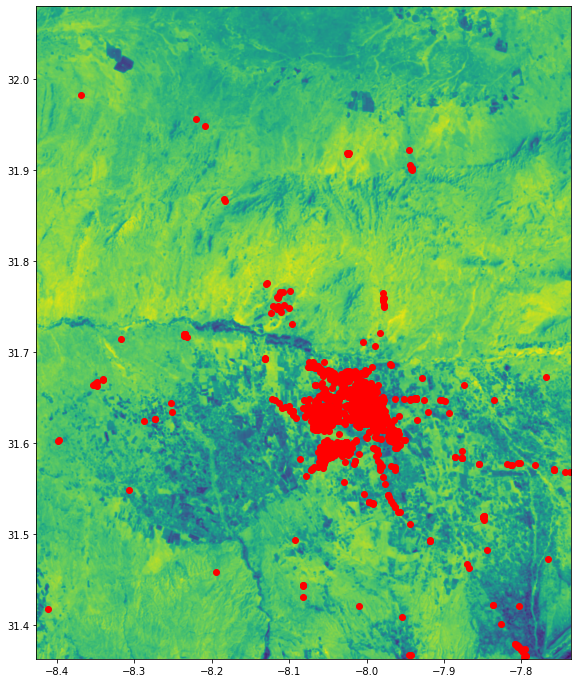

In [ ]:
# plot raster data with amenities
fig, ax = plt.subplots(figsize=(12, 12))
rasterio.plot.show(city_lst_mean_r, ax=ax)
city_amenity.plot(ax=ax, facecolor='r', edgecolor='r')

## Extract LST values for amanity location

In [ ]:
# get amenity coordinates
city_amenity_coords = [(x,y) for x, y in zip(city_amenity.longitude, city_amenity.latitude)]
# extract lst values for amaenity coordinates
city_amenity['lstMean'] = [x[0] for x in city_lst_mean_r.sample(city_amenity_coords)]

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
city_amenity.lstMean.describe()

count    1761.000000
mean       40.632251
std         1.750360
min        33.519362
25%        39.497434
50%        40.236623
75%        41.434837
max        49.956750
Name: lstMean, dtype: float64

In [ ]:
#######################################################################################################################
# plot amenity exposure to LST within one city  
#######################################################################################################################

fig = px.scatter_mapbox(city_amenity, lat="latitude", lon="longitude", hover_name="featureType", hover_data=["lstMean", "cityName"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300, color = "lstMean")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Compute amenity exposure indicator by city

In [ ]:
def compute_amenity_exposure_to_LST(administrative_boundaries_gdf, 
                                    amenity_gdf,
                                    lst_mean_threshold):
  """ Compute amenity exposure to land surface temperature 
 
        inputs:
         administrative_boundaries_gdf (geodataframe): The administrative boundaries of cities
         amenity_gdf (geodataframe): The location of amenities within cities
         lst_mean_threshold (float): Temperature threshold above it an amenity is considered exposed to lst hazard
    
        Returns:
         city_geo_indicators (geodataframe): geopandas dataframe containing indicators of cities' amenities exposure to lst hazards
 
    """
  print("\n create empty dataframe")
  city_geo_indicators = administrative_boundaries_gdf[["id","name","geometry"]]
  print("\n loop on cities")
  for i in range(len(city_geo_indicators)):
    cityId = city_geo_indicators.loc[i, 'id']
    cityName = city_geo_indicators.loc[i, 'name']
    print("\n City Id: "+cityId)
    # select amenity data for the selectd city
    city_amenity =  amenity_gdf[amenity_gdf.cityName == cityName]
    # select boundaries data for the selected city
    city_boundaries =  administrative_boundaries_gdf[administrative_boundaries_gdf.name == cityName]
    # select LST data
    fpath = "https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-"+cityId+".tif"
    print("\n path: "+fpath)
    city_lst_mean_r = rasterio.open(fpath)
    # get amenity coordinates
    city_amenity_coords = [(x,y) for x, y in zip(city_amenity.longitude, city_amenity.latitude)]
    # extract lst values for amenity coordinates
    city_amenity['lstMean'] = [x[0] for x in city_lst_mean_r.sample(city_amenity_coords)]
    # compute number of amenities exposed to temperature above and under threshold
    city_amenity_exposure = (city_amenity 
                            .groupby("cityName")
                            .agg(nbAmenityExposed=pd.NamedAgg(column='lstMean', aggfunc=lambda x: (x > lst_mean_threshold).sum()), 
                                nbAmenityNotExposed=pd.NamedAgg(column='lstMean', aggfunc=lambda x: (x < lst_mean_threshold).sum()))
                            .reset_index()
                            )
    print("\n city_amenity_exposure: ")
    print(city_amenity_exposure)
    print("\n successifully computed indicator for: "+cityId)
    city_geo_indicators.loc[i, 'nbAmenityExposed'] = city_amenity_exposure.nbAmenityExposed.values[0]
    city_geo_indicators.loc[i, 'nbAmenityNotExposed'] = city_amenity_exposure.nbAmenityNotExposed.values[0]
    # compute percent of exposed amenities
    city_geo_indicators['percentAmenityExposed'] = round(city_geo_indicators['nbAmenityExposed']/(city_geo_indicators['nbAmenityExposed'] + city_geo_indicators['nbAmenityNotExposed']),2)
  

  return city_geo_indicators 

In [ ]:
city_geo_indicators = compute_amenity_exposure_to_LST(administrative_boundaries_gdf = admin_boundaries_urbanshift_cities,
                                                      amenity_gdf = amenity_urbanshift_cities,
                                                      lst_mean_threshold = 30)


 create empty dataframe

 loop on cities

 City Id: ARG-Mendoza

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Mendoza.tif


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata


 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0  Mendoza             108.0               3130.0

 successifully computed indicator for: ARG-Mendoza

 City Id: ARG-Mar_del_Plata

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Mar_del_Plata.tif

 city_amenity_exposure: 
        cityName  nbAmenityExposed  nbAmenityNotExposed
0  Mar del Plata               0.0                827.0

 successifully computed indicator for: ARG-Mar_del_Plata

 City Id: ARG-Ushuaia

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Ushuaia.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0  Ushuaia               0.0                272.0

 successifully computed indicator for: ARG-Ushuaia

 City Id: ARG-Salta

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Salta.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0    Salta              12.0               1246.0

 successifully computed indicator for: ARG-Salta

 City Id: ARG-Buenos_Aires

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-ARG-Buenos_Aires.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
       cityName  nbAmenityExposed  nbAmenityNotExposed
0  Buenos Aires              13.0              11775.0

 successifully computed indicator for: ARG-Buenos_Aires

 City Id: BRA-Teresina

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-BRA-Teresina.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
   cityName  nbAmenityExposed  nbAmenityNotExposed
0  Teresina            1930.0                  1.0

 successifully computed indicator for: BRA-Teresina

 City Id: BRA-Florianopolois

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-BRA-Florianopolois.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
         cityName  nbAmenityExposed  nbAmenityNotExposed
0  Florianopolois               0.0               2752.0

 successifully computed indicator for: BRA-Florianopolois

 City Id: BRA-Belem

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-BRA-Belem.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0    Belem            1114.0                  1.0

 successifully computed indicator for: BRA-Belem

 City Id: CRI-San_Jose

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-CRI-San_Jose.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
   cityName  nbAmenityExposed  nbAmenityNotExposed
0  San Jose            4854.0               1298.0

 successifully computed indicator for: CRI-San_Jose

 City Id: RWA-Kigali

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-RWA-Kigali.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0   Kigali             453.0                 68.0

 successifully computed indicator for: RWA-Kigali

 City Id: MAR-Marrakech

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-MAR-Marrakech.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
    cityName  nbAmenityExposed  nbAmenityNotExposed
0  Marrakech            1761.0                  0.0

 successifully computed indicator for: MAR-Marrakech

 City Id: IND-Chennai

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IND-Chennai.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0  Chennai            6468.0                 47.0

 successifully computed indicator for: IND-Chennai

 City Id: IND-Pune

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IND-Pune.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0     Pune            3901.0                128.0

 successifully computed indicator for: IND-Pune

 City Id: IND-Surat

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IND-Surat.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0    Surat            1660.0                  2.0

 successifully computed indicator for: IND-Surat

 City Id: CHN-Chengdu

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-CHN-Chengdu.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0  Chengdu            1717.0                354.0

 successifully computed indicator for: CHN-Chengdu

 City Id: CHN-Chongqing

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-CHN-Chongqing.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
    cityName  nbAmenityExposed  nbAmenityNotExposed
0  Chongqing            1615.0                345.0

 successifully computed indicator for: CHN-Chongqing

 City Id: CHN-Ningbo

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-CHN-Ningbo.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0   Ningbo            2304.0                103.0

 successifully computed indicator for: CHN-Ningbo

 City Id: IDN-Jakarta

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Jakarta.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0  Jakarta           10990.0                 27.0

 successifully computed indicator for: IDN-Jakarta

 City Id: IDN-Bitung

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Bitung.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
  cityName  nbAmenityExposed  nbAmenityNotExposed
0   Bitung             335.0                 28.0

 successifully computed indicator for: IDN-Bitung

 City Id: IDN-Semarang

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Semarang.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
   cityName  nbAmenityExposed  nbAmenityNotExposed
0  Semarang            2180.0                 27.0

 successifully computed indicator for: IDN-Semarang

 City Id: IDN-Balikpapan

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Balikpapan.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
     cityName  nbAmenityExposed  nbAmenityNotExposed
0  Balikpapan               6.0                 10.0

 successifully computed indicator for: IDN-Balikpapan

 City Id: IDN-Palembang

 path: https://storage.googleapis.com/urbanshift/lst/lst_Mean/lst-IDN-Palembang.tif


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 city_amenity_exposure: 
    cityName  nbAmenityExposed  nbAmenityNotExposed
0  Palembang             437.0                 26.0

 successifully computed indicator for: IDN-Palembang


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
display(city_geo_indicators)

,id,name,geometry,nbAmenityExposed,nbAmenityNotExposed,percentAmenityExposed
0,ARG-Mendoza,Mendoza,"MULTIPOLYGON (((-70.09376 -33.05128, -70.09369...",108.0,3130.0,0.03
1,ARG-Mar_del_Plata,Mar del Plata,"MULTIPOLYGON (((-58.04728 -37.95562, -58.04717...",0.0,827.0,0.00
2,ARG-Ushuaia,Ushuaia,"MULTIPOLYGON (((-64.35062 -54.84401, -64.35014...",0.0,272.0,0.00
3,ARG-Salta,Salta,"MULTIPOLYGON (((-65.53171 -25.02690, -65.53166...",12.0,1246.0,0.01
4,ARG-Buenos_Aires,Buenos Aires,"MULTIPOLYGON (((-58.36618 -34.59744, -58.36609...",13.0,11775.0,0.00
5,BRA-Teresina,Teresina,"MULTIPOLYGON (((-42.59900 -5.35000, -42.60100 ...",1930.0,1.0,1.00
6,BRA-Florianopolois,Florianopolois,"MULTIPOLYGON (((-48.58167 -27.76205, -48.57442...",0.0,2752.0,0.00
7,BRA-Belem,Belem,"MULTIPOLYGON (((-48.54139 -1.35451, -48.53229 ...",1114.0,1.0,1.00
8,CRI-San_Jose,San Jose,"MULTIPOLYGON (((-83.76411 9.60486, -83.76250 9...",4854.0,1298.0,0.79
9,RWA-Kigali,Kigali,"MULTIPOLYGON (((29.97953 -1.88664, 29.98450 -1...",453.0,68.0,0.87


# Ouput data

## Explore output

### Map of cities with amenity exposure level

In [ ]:
geo_df = city_geo_indicators.set_index("name")

fig = px.choropleth_mapbox(geo_df,
                           geojson=geo_df.geometry,
                           locations=geo_df.index,
                           color="percentAmenityExposed",
                           #center={"lat": 45.5517, "lon": -73.7073},
                           mapbox_style="carto-positron", #"open-street-map"
                           color_continuous_scale="Bluered", #https://plotly.com/python/builtin-colorscales/
                           zoom=1,
                           #hover_data=["nbAmenityExposed"],
                           hover_name="id",
                           )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

### Comparison of city exposure

In [ ]:
fig = px.bar(city_geo_indicators.sort_values(by=['percentAmenityExposed']), x='name', y='percentAmenityExposed')
fig.show()

## Export Ouput

### Export to Google Cloud Storage

In [ ]:
# convert into geojson
city_geo_indicators_geojson = city_geo_indicators.to_json()
# instatiate a google storage client and specify reauired bucket and file
storgae_client = storage.Client("wri-gee")
bucket = storgae_client.get_bucket('urbanshift')
# define path for writing data
blobName = 'city_baseline_indicators.geojson'

# Create a new blob and upload the file's content.
blob = bucket.blob(blobName)
blob.upload_from_string(city_geo_indicators_geojson)

### Export to Big Table

### Export to Github